<a href="https://colab.research.google.com/github/leguiart/Deep-Learning/blob/main/tarea_2e2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 2: Reconocimiento de acciones humanas usando RNNs 



---
---

Se emplea un modelo basado en RNNs y otro en una CNN1D para reconocimiento de acciones humanas (HAR) en el conjunto [UCF11](https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php).

<img src="https://www.cs.ucf.edu/~liujg/realistic_actions/youtube_snaps.jpg" />


## 1 Preparación

### 1.1 Bibliotecas

In [4]:
# Colab
# https://github.com/TylerYep/torchinfo
!pip install torchinfo
# https://zarr.readthedocs.io/en/stable/
!pip install zarr

     |████████████████████████████████| 146 kB 4.3 MB/s 
     |████████████████████████████████| 6.2 MB 13.2 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5051 sha256=b9971ae26ff056daa2af4f66e627de03e906d63f9170a4365f47151a6cb29281
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [39]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import math
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary

# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2 Datos

### 2.1 Conjunto de datos

In [40]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

### 2.2 Instancia del conjunto y partición

In [41]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

Files already downloaded and verified
x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


In [42]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### 2.3 Cargadores de datos

In [43]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

In [44]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3 Modelo

<!-- Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes.  -->

### 3.1 Definición de arquitectura

In [119]:
class BiRNN(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_layers = 1, num_classes=11, subsampling = 'last_step'):
        super().__init__()
        self.subsampling = subsampling
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 para bidirección
    
    def forward(self, x):
        # Establece estados iniciales
        h0 = torch.zeros(self.num_layers*2, x.size()[0], self.hidden_size).to(device)# 2 para bidirección 
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        
        # Propagación hacia adelante de la GRU
        # [B, S, F] => [B, S, H]
        out, _ = self.rnn(x, h0)  # out: tensor de la forma (batch_size, seq_length, hidden_size*2)
        
        # Decodifica el estado oculto del último paso de tiempo
        if self.subsampling == "last_step":
          out = self.fc(out[:, -1, :])
        # Se toma el promedio de la secuencia
        elif self.subsampling == "mean":
          out = self.fc(torch.mean(out, 1))
        else:
          raise ValueError("invalid subsampling parameter: Must be either 'last_step' or 'mean'")
        return out


class CNN1DModule(nn.Module):
  def __init__(self, in_channels = 10, out_channels = 512, num_classes = 11, kernel_size = 5, stride = 2, padding = 0, dilation = 1):
    super().__init__()
    self.feats = 256*249
    self.cnn = nn.Sequential(
      #[B, 10, 1024] => [B, 512, 510]
      nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation),
      #[B, 512, 510] => [B, 512, 510]
      nn.BatchNorm1d(out_channels),
      #[B, 512, 510] => [B, 256, 253]
      nn.Conv1d(in_channels = out_channels, out_channels = out_channels//2, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation),
      #[B, 256, 253] => [B, 256, 253]
      nn.BatchNorm1d(out_channels//2),
      #[B, 256, 253] => [B, 256, 249]
      nn.Conv1d(in_channels = out_channels//2, out_channels = out_channels//2, kernel_size = kernel_size, stride = stride//2, padding = padding, dilation = dilation),
      # #[B, 256, 249] => [B, 256, 249]
      nn.BatchNorm1d(out_channels//2)
    )
    #[B, 256, 125] => 256x125
    self.flatten = nn.Flatten()
    #[B, 256x125] => [B, 11]
    self.fc = nn.Sequential(
        # nn.ReLU(),
        # nn.Linear(self.feats, 20),
        nn.ReLU(),
        nn.Linear(self.feats, num_classes)
      )
    
  def forward(self, x):
    cnn_out = self.cnn(x)
    cnn_flatten = self.flatten(cnn_out)
    out = self.fc(cnn_flatten)
    return out



In [127]:
model_last = BiRNN(num_layers=4).to(device).eval()
model_mean = BiRNN(num_layers=4, subsampling='mean').to(device).eval()
model_cnn1d = CNN1DModule().eval()

In [129]:
model_last(torch.zeros(1, 10, 1024).to(device)).shape

torch.Size([1, 11])

In [130]:
model_mean(torch.zeros(1, 10, 1024).to(device)).shape

torch.Size([1, 11])

In [131]:
model_cnn1d(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

### 3.2 Inspección de arquitectura

In [132]:
summary(model_mean, (1, 10, 1024), device = device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    --                        --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              1,775,616
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 1,780,491
Trainable params: 1,780,491
Non-trainable params: 0
Total mult-adds (M): 17.76
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 7.12
Estimated Total Size (MB): 7.27

In [133]:
summary(model_last, (1, 10, 1024), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    --                        --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 256]              1,775,616
├─Linear: 1-3                            [1, 11]                   2,827
Total params: 1,780,491
Trainable params: 1,780,491
Non-trainable params: 0
Total mult-adds (M): 17.76
Input size (MB): 0.04
Forward/backward pass size (MB): 0.10
Params size (MB): 7.12
Estimated Total Size (MB): 7.27

In [134]:
summary(model_cnn1d, (1, 10, 1024), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN1DModule                              --                        --
├─Sequential: 1-1                        [1, 256, 249]             --
│    └─Conv1d: 2-1                       [1, 512, 510]             26,112
│    └─BatchNorm1d: 2-2                  [1, 512, 510]             1,024
│    └─Conv1d: 2-3                       [1, 256, 253]             655,616
│    └─BatchNorm1d: 2-4                  [1, 256, 253]             512
│    └─Conv1d: 2-5                       [1, 256, 249]             327,936
│    └─BatchNorm1d: 2-6                  [1, 256, 249]             512
├─Flatten: 1-2                           [1, 63744]                --
├─Sequential: 1-3                        [1, 11]                   --
│    └─ReLU: 2-7                         [1, 63744]                --
│    └─Linear: 2-8                       [1, 11]                   701,195
Total params: 1,712,907
Trainable params: 1,712,907
Non-train

## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

In [144]:
def eval_epoch(model, dl):
  # desactivamos temporalmente la gráfica de cómputo
  with torch.no_grad():

      # modelo en modo de evaluación
      model.eval()
      
      losses, accs = [], []
      # validación de la época
      for x, y_true in dl:
          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.to(device)
          # hacemos inferencia para obtener los logits
          y_lgts = model(x)
          # calculamos las probabilidades
          y_prob = F.softmax(y_lgts, 1)
          # obtenemos la clase predicha
          y_pred = torch.argmax(y_prob, 1)
          
          # calculamos la pérdida
          loss = F.cross_entropy(y_lgts, y_true)
          # calculamos la exactitud
          acc = (y_true == y_pred).type(torch.float32).mean()

          # guardamos históricos
          losses.append(loss.item() * 100)
          accs.append(acc.item() * 100)

      # imprimimos métricas
      loss = np.mean(losses)
      acc = np.mean(accs)
      return loss, acc


def train(model):
  # optimizador
  opt = optim.Adam(model.parameters(), lr=1e-3)
  trn_loss_hist, trn_acc_hist, tst_loss_hist, tst_acc_hist = [], [], [], []
  # ciclo de entrenamiento
  EPOCHS = 20
  for epoch in range(EPOCHS):

      # modelo en modo de entrenamiento
      model.train()
      
      # entrenamiento de una época
      for x, y_true in trn_dl:
          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.to(device)
          # hacemos inferencia para obtener los logits
          y_lgts = model(x)
          # calculamos la pérdida
          loss = F.cross_entropy(y_lgts, y_true)
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          loss.backward()
          # actulizamos parámetros
          opt.step()
      #Validación en entrenamiento
      loss_trn, acc_trn = eval_epoch(model, trn_dl)
      #Validación en prueba
      loss_tst, acc_tst = eval_epoch(model, tst_dl)
      trn_loss_hist.append(loss_trn)
      trn_acc_hist.append(acc_trn)
      tst_loss_hist.append(loss_tst)
      tst_acc_hist.append(acc_tst)
      print(f'E{epoch:2} loss={loss_tst:6.2f} acc={acc_tst:.2f}')
  return trn_loss_hist, trn_acc_hist, tst_loss_hist, tst_acc_hist

In [145]:
model_last = BiRNN(num_layers=4).to(device)
model_mean = BiRNN(num_layers=4, subsampling='mean').to(device)
model_cnn1d = CNN1DModule().to(device)

In [146]:
trn_loss_hist_rnn_l, trn_acc_hist_rnn_l, tst_loss_hist_rnn_l, tst_acc_hist_rnn_l = train(model_last)

E 0 loss=195.86 acc=35.31
E 1 loss=159.46 acc=50.94
E 2 loss=175.96 acc=47.19
E 3 loss=160.52 acc=50.31
E 4 loss=173.72 acc=52.19
E 5 loss=192.83 acc=51.56
E 6 loss=194.73 acc=50.00
E 7 loss=190.93 acc=55.62
E 8 loss=205.38 acc=53.44
E 9 loss=221.62 acc=50.94
E10 loss=217.91 acc=52.50
E11 loss=207.73 acc=54.38
E12 loss=229.74 acc=53.44
E13 loss=242.53 acc=53.12
E14 loss=245.35 acc=52.50
E15 loss=209.82 acc=56.56
E16 loss=216.69 acc=54.38
E17 loss=212.03 acc=57.19
E18 loss=223.18 acc=56.88
E19 loss=216.25 acc=55.62


In [147]:
trn_loss_hist_rnn_m, trn_acc_hist_rnn_m, tst_loss_hist_rnn_m, tst_acc_hist_rnn_m = train(model_mean)

E 0 loss=183.60 acc=40.31
E 1 loss=165.57 acc=48.12
E 2 loss=151.38 acc=54.38
E 3 loss=162.34 acc=52.50
E 4 loss=170.47 acc=53.44
E 5 loss=168.78 acc=52.50
E 6 loss=179.10 acc=57.50
E 7 loss=188.55 acc=54.38
E 8 loss=173.37 acc=57.81
E 9 loss=186.34 acc=55.62
E10 loss=176.58 acc=57.50
E11 loss=183.21 acc=57.19
E12 loss=194.40 acc=56.56
E13 loss=203.75 acc=55.62
E14 loss=195.20 acc=57.50
E15 loss=191.91 acc=58.75
E16 loss=199.17 acc=56.25
E17 loss=206.03 acc=56.56
E18 loss=199.54 acc=56.56
E19 loss=218.02 acc=57.50


In [148]:
trn_loss_hist_cnn, trn_acc_hist_cnn, tst_loss_hist_cnn, tst_acc_hist_cnn = train(model_cnn1d)

E 0 loss=314.23 acc=22.50
E 1 loss=291.00 acc=29.38
E 2 loss=284.09 acc=29.38
E 3 loss=197.89 acc=42.81
E 4 loss=204.96 acc=39.06
E 5 loss=203.41 acc=43.75
E 6 loss=236.98 acc=37.81
E 7 loss=248.24 acc=42.19
E 8 loss=223.06 acc=46.25
E 9 loss=212.71 acc=43.12
E10 loss=199.99 acc=49.06
E11 loss=212.28 acc=42.19
E12 loss=269.55 acc=34.69
E13 loss=200.33 acc=42.50
E14 loss=193.09 acc=48.75
E15 loss=231.64 acc=41.56
E16 loss=235.61 acc=45.94
E17 loss=233.90 acc=43.12
E18 loss=214.27 acc=46.25
E19 loss=227.85 acc=39.69


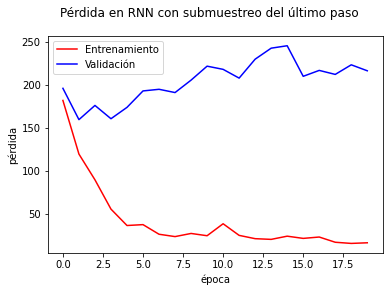

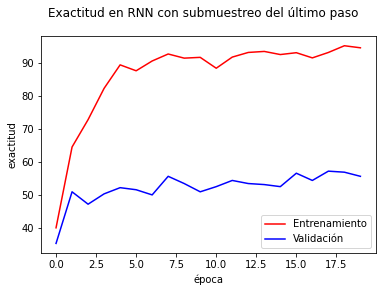

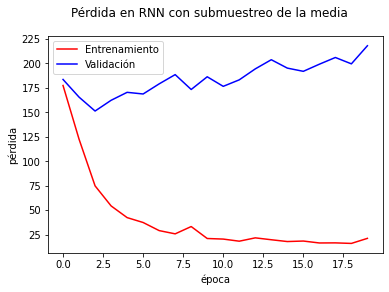

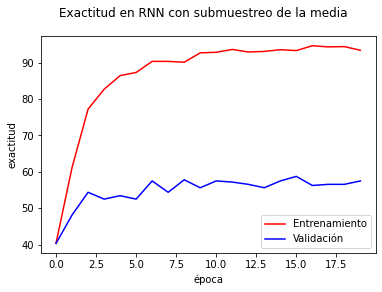

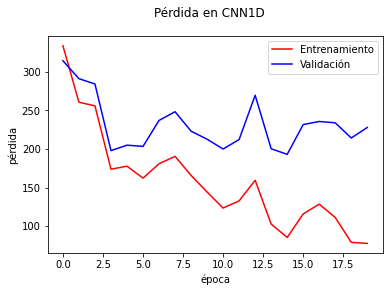

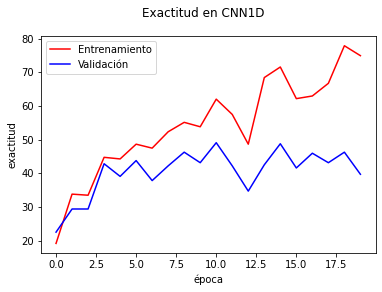

In [155]:
# gráficas
import matplotlib.pyplot as plt
plt.plot(trn_loss_hist_rnn_l, color='red', label = "Entrenamiento")
plt.plot(tst_loss_hist_rnn_l, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('pérdida')
plt.suptitle('Pérdida en RNN con submuestreo del último paso')
plt.legend()
plt.show()

plt.plot(trn_acc_hist_rnn_l, color='red', label = "Entrenamiento")
plt.plot(tst_acc_hist_rnn_l, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('exactitud')
plt.suptitle('Exactitud en RNN con submuestreo del último paso')
plt.legend()
plt.show()

plt.plot(trn_loss_hist_rnn_m, color='red', label = "Entrenamiento")
plt.plot(tst_loss_hist_rnn_m, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('pérdida')
plt.suptitle('Pérdida en RNN con submuestreo de la media')
plt.legend()
plt.show()

plt.plot(trn_acc_hist_rnn_m, color='red', label = "Entrenamiento")
plt.plot(tst_acc_hist_rnn_m, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('exactitud')
plt.suptitle('Exactitud en RNN con submuestreo de la media')
plt.legend()
plt.show()


plt.plot(trn_loss_hist_cnn, color='red', label = "Entrenamiento")
plt.plot(tst_loss_hist_cnn, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('pérdida')
plt.suptitle('Pérdida en CNN1D')
plt.legend()
plt.show()

plt.plot(trn_acc_hist_cnn, color='red', label = "Entrenamiento")
plt.plot(tst_acc_hist_cnn, color='blue', label = "Validación")
plt.xlabel('época')
plt.ylabel('exactitud')
plt.suptitle('Exactitud en CNN1D')
plt.legend()
plt.show()

## 5 Discusión
Las RNN Bidireccionales con muestreo del último paso y de la media tuvieron resultados similares. Ambas presentaron un pobre desempeño en cuanto a exactitud se refiere en validación y altos porcentajes de exactitud en entrenamiento, sugiriendo un sobreajuste. Aunque no se muestra en los resultados, se pudo observar que aumentar la cantidad de parámetros pasando de una a cuatro capas mejoró el desempeño de la RNN con submuestreo en el último paso. Se presenta una historia similar para la red neuronal convolucional 1D en cuanto a una posible deficiencia en cuanto a la generalización, sólo que en este caso se tuvo un peor desempeño que con las RNN.